In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
import mltools as ml
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
import time

%matplotlib inline
np.random.seed(0)
iris = np.genfromtxt("data/iris.txt",delimiter=None) # load the text fi le
Y = iris[:,-1] # target value is the last column
X = iris[:,0:-1] # features are the other columns

In [2]:
X,Y = ml.shuffleData(X,Y)
Xtr,Xva,Ytr,Yva = ml.splitData(X,Y, 0.8) # getting training and validati on data set

### Empirical P-Value (using Naive Bayes Model)

In [3]:
class EmpiricalGaussianClassifier:
    
    def __init__(self, X="None", Y="None"):
        if X == "None" or Y == "None":
            return
        self.fit(X, Y)
        
        
    def fit(self, X, Y):
        self.classes, self.counts = np.unique(Y, return_counts=True)  #[A, B, ...],  [numA, numB, ..]
        self.model = GaussianNB()
        self.model.fit(X, Y)
#         self.centers = np.array([np.mean(X[Y==c, :], axis=0) for c in self.classes]) # [centerA, centerB, ...]
#         self.distances = np.array([euclidean_distances(X[Y==c], [centers[i,:]]).T[0] for (i, c) in zip(range(len(self.centers)), self.classes)])  # [distancesA, distancesB, ...]
        allProbas = self.model.predict_proba(X)
        self.probas = np.array([allProbas[Y==c, i] for i, c in enumerate(self.classes)])  # [probasForClassA, probasForClassB, ..]
        
        
           
    def p_value(self, x):
        """
        x: feature vector
        return: p value for each of the class
        """
        xProba = self.model.predict_proba(np.atleast_2d(x))[0]
        p_val = np.array([(np.sum(xProba[i] >= self.probas[i]) / self.counts[i] if np.sum(xProba[i] >= self.probas[i]) / self.counts[i] < 0.5 else 1 - np.sum(xProba[i] >= self.probas[i]) / self.counts[i]) for i in range(len(self.classes))])
        return p_val
    
    
    def all_p_values(self, X):
        """
        X: r by c
        return: p values of each of the class for all data points
        """
        return np.array([self.p_value(x) for x in X])
    
    
    def predictProba(self, x):
        """
        x: feature vector
        return: probability for each of the class
        """
        return self.model.predict_proba(np.atleast_2d(x))[0]
    
    
    def all_probas(self, X):
        """
        X: r by c
        return: all the proabability for each of the class for all data points
        """
        return np.array([self.predictProba(x) for x in X])
    
    
    def predictClass(self, X):
        """
        X: r by c
        return: predcit the class that has the highest p-value
        """
        return np.argmax(self.all_p_values(X), axis=1)
        
        
    
    def score(self, X, Y, all_p_vals="None"):
        """
        X: r by c
        threshold: pvalue threshold
        return: the accuracy
        """
        if all_p_vals == "None":
            all_p_vals = self.all_p_values(X)
        return np.sum(np.argmax(all_p_vals, axis=1) == Y) / X.shape[0]

In [4]:
egc = EmpiricalGaussianClassifier(Xtr, Ytr)
print(egc.all_p_values(Xva))
print(egc.score(Xva, Yva))

[[0.         0.08333333 0.05128205]
 [0.         0.         0.07692308]
 [0.         0.         0.05128205]
 [0.         0.05555556 0.1025641 ]
 [0.         0.38888889 0.        ]
 [0.         0.         0.30769231]
 [0.         0.13888889 0.        ]
 [0.         0.02777778 0.12820513]
 [0.         0.         0.41025641]
 [0.         0.13888889 0.        ]
 [0.         0.         0.38461538]
 [0.         0.         0.05128205]
 [0.         0.44444444 0.        ]
 [0.         0.33333333 0.        ]
 [0.11627907 0.         0.        ]
 [0.         0.25       0.        ]
 [0.         0.         0.46153846]
 [0.         0.         0.30769231]
 [0.         0.         0.        ]
 [0.         0.33333333 0.        ]
 [0.         0.30555556 0.        ]
 [0.         0.30555556 0.        ]
 [0.         0.41666667 0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.23076923]
 [0.         0.38888889 0.  

d:\johnathan\python\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


### Theoretical P-Value (using Multivariant Gaussian Distribution)

In [5]:
class TheoreticalGaussianClassifier:

    def __init__(self, X="None", Y="None"):
        if X == "None" or Y == "None":
            return
        self.fit(X, Y)

    def fit(self, X, Y):
        self.classes, self.counts = np.unique(Y, return_counts=True)  # [A, B, ...],  [numA, numB, ..]
        self.centers = np.array([np.mean(X[Y == c, :], axis=0) for c in self.classes])  # [centerA, centerB, ...]
        self.covs = np.array([np.cov(X[Y == c, :], rowvar=False) for c in self.classes])  # [covA, covB, ...]
        self.distributions = np.array([multivariate_normal(mean=self.centers[i], cov=self.covs[i], allow_singular=True) for i, c in
                                       enumerate(self.classes)])  # [disA, disB, ...]

    def p_value(self, x):
        """
        x: feature vector
        return: p value for each of the class
        """
        res=np.zeros((len(self.classes),))
        for i in range(len(self.classes)):
            t0=time.time()
            cdfx = self.distributions[i].cdf(x)
            cdfx=cdfx if cdfx<0.5 else 1-cdfx
            res[i]=cdfx
        return res


    def all_p_values(self, X):
        """
        X: r by c
        return: p values of each of the class for all data points
        """
        return np.array([self.p_value(x) * 2 for x in X])


    def predictClass(self, X):
        """
        X: r by c
        return: predcit the class that has the highest p-value
        """
        return np.argmax(self.all_p_values(X), axis=1)

    def score(self, X, Y, all_p_vals="None"):
        """
        X: r by c
        threshold: pvalue threshold
        return: the accuracy
        """
        if all_p_vals == "None":
            all_p_vals = self.all_p_values(X)
        return np.sum(np.argmax(all_p_vals, axis=1) == Y) / X.shape[0]

In [6]:
tgc = TheoreticalGaussianClassifier(Xtr, Ytr)
print(tgc.score(Xva, Yva))

0.8


d:\johnathan\python\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


## Plot for Therotical P-value method

In [7]:
allDataTgc = TheoreticalGaussianClassifier(X, Y)

d:\johnathan\python\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


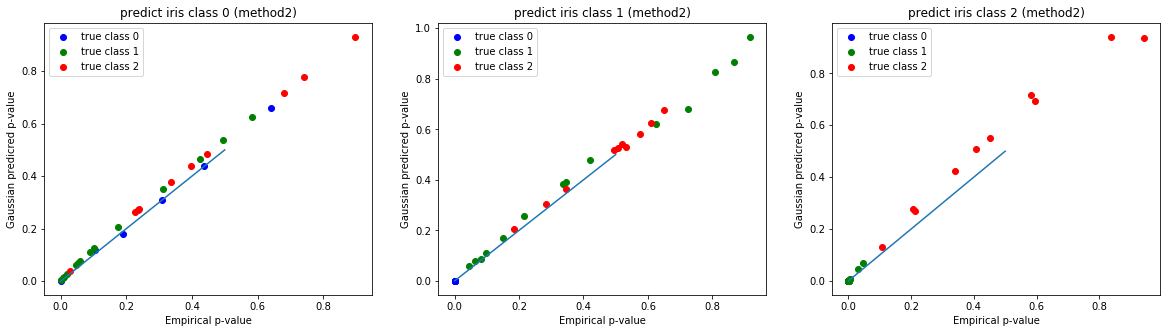

In [8]:
colors = ['blue', 'green', 'red']
fig, ax = plt.subplots(1, 3, figsize=(20,5))
for i in range(3):
    ax[i].plot(np.linspace(0, 0.5, 1000), np.linspace(0, 0.5, 1000))
    for j in range(3):
        mask = Yva==j
        ax[i].scatter(allDataTgc.all_p_values(Xva)[mask,i], tgc.all_p_values(Xva)[mask,i], c=colors[j], label=f"true class {j}")
    ax[i].set_title(f"predict iris class {i} (method2)")
    ax[i].set_xlabel("Empirical p-value")
    ax[i].set_ylabel("Gaussian predicred p-value")
    ax[i].legend()
plt.show()

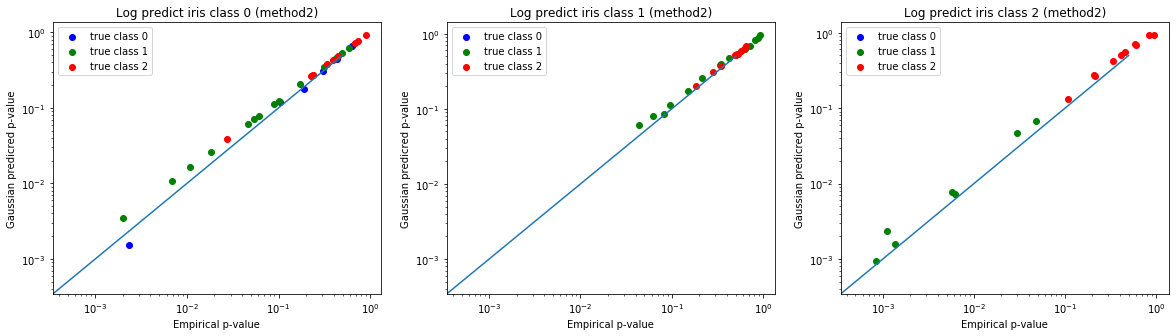

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
for i in range(3):
    ax[i].plot(np.linspace(0, 0.5, 1000), np.linspace(0, 0.5, 1000))
    for j in range(3):
        mask = Yva==j
        ax[i].scatter(allDataTgc.all_p_values(Xva)[mask,i], tgc.all_p_values(Xva)[mask,i], c=colors[j], label=f"true class {j}")
    ax[i].set_title(f"Log predict iris class {i} (method2)")
    ax[i].set_xlabel("Empirical p-value")
    ax[i].set_ylabel("Gaussian predicred p-value")
    ax[i].legend()
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
plt.show()

## Plot for Empirical P-value

In [10]:
allDataEgc = EmpiricalGaussianClassifier(X, Y)

d:\johnathan\python\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


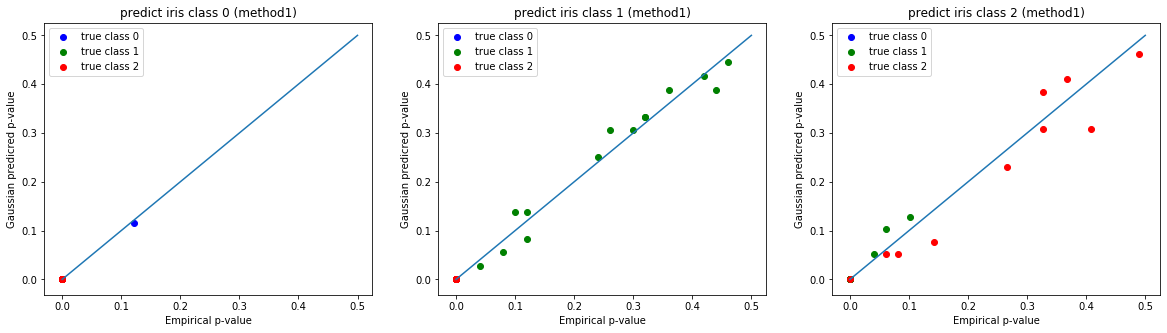

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
for i in range(3):
    ax[i].plot(np.linspace(1e-10, 0.5, 1000), np.linspace(1e-10, 0.5, 1000))
    for j in range(3):
        mask = Yva==j
        ax[i].scatter(allDataEgc.all_p_values(Xva)[mask,i], egc.all_p_values(Xva)[mask,i], c=colors[j], label=f"true class {j}")
    ax[i].set_title(f"predict iris class {i} (method1)")
    ax[i].set_xlabel("Empirical p-value")
    ax[i].set_ylabel("Gaussian predicred p-value")
    ax[i].legend()
plt.show()

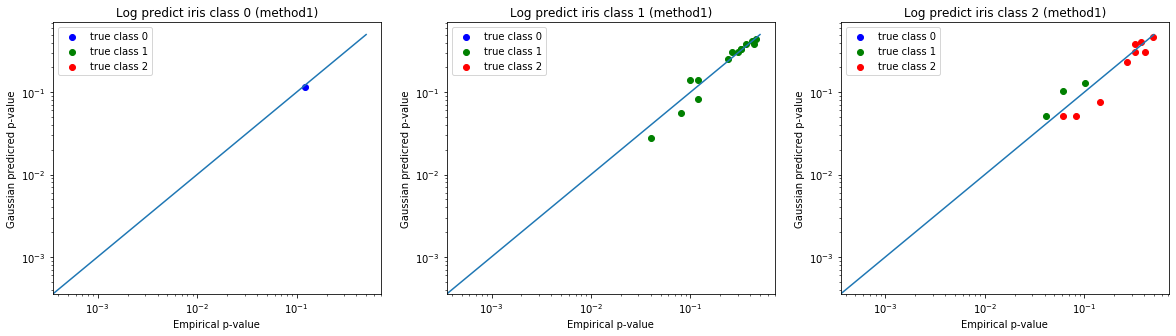

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
for i in range(3):
    ax[i].plot(np.linspace(0, 0.5, 1000), np.linspace(0, 0.5, 1000))
    for j in range(3):
        mask = Yva==j
        ax[i].scatter(allDataEgc.all_p_values(Xva)[mask,i], egc.all_p_values(Xva)[mask,i], c=colors[j], label=f"true class {j}")
    ax[i].set_title(f"Log predict iris class {i} (method1)")
    ax[i].set_xlabel("Empirical p-value")
    ax[i].set_ylabel("Gaussian predicred p-value")
    ax[i].legend()
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
plt.show()

### Wine

In [13]:
DATA=np.loadtxt("data/wine.data", delimiter=',')
X = DATA[:,1:]
Y = DATA[:,0]
Y = Y - 1
Y = np.array(Y, dtype=np.int)
DATA = np.concatenate((X, np.reshape(Y, (len(Y), 1))), axis=1)
np.random.shuffle(DATA)
training_portion = 0.8
index = int(len(DATA) * training_portion)
TRAIN = DATA[:index, :]
TEST  = DATA[index:, :]
Xtrain, Ytrain = TRAIN[:, :-1], TRAIN[:, -1]
Xtest , Ytest  = TEST[:, :-1], TEST[:, -1]
Ytrain = np.array(Ytrain, dtype=np.int)
Ytest = np.array(Ytest, dtype=np.int)
print(X.shape)
print(Y.shape)
print(np.unique(Ytrain))
print(Ytest.shape)

(178, 13)
(178,)
[0 1 2]
(36,)


In [14]:
egc = EmpiricalGaussianClassifier(Xtrain, Ytrain)
print(egc.score(Xtest, Ytest))

0.7777777777777778


d:\johnathan\python\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


In [15]:
tgc = TheoreticalGaussianClassifier(Xtrain, Ytrain)
print(tgc.score(Xtest, Ytest))

d:\johnathan\python\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


0.6666666666666666


### Bio grid

In [16]:
DATA = []
classes = {}
with open("data/All_bio_grid_data.txt", 'r') as f:
    for line in f:
        line = (line.rstrip().split(' '))
        classes.setdefault(line[-1], len(classes))
        line[-1] = classes[line[-1]]
        DATA.append(line)
DATA = np.array(DATA, dtype=np.float)
X = DATA[:, :-1]
Y = DATA[:, -1]
Y = np.array(Y, dtype = np.int)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.20, random_state=42)
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape
print(Xtrain.shape)
print(np.unique(Ytrain))

(26875, 30)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80]


In [17]:
t0 = time.time()
egc = EmpiricalGaussianClassifier(Xtrain, Ytrain)
print(egc.score(Xtest, Ytest))
print("time:", time.time() - t0)

d:\johnathan\python\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


0.38502753385920524
time: 28.802835702896118


In [19]:
t0 = time.time()
tgc = TheoreticalGaussianClassifier(Xtrain, Ytrain)
print(tgc.score(Xtest[:10], Ytest[:10]))
print("time:", time.time() - t0)

d:\johnathan\python\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


0.0
time: 176.14587569236755
